In [1]:
# Setup library
## install -r requirements.txt
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [2]:
# Classifier from TF hub
import numpy as np

classifier_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2' #@param {type:"string"}
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])
## And labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [3]:
# prepare dataset
import os

dataset_root = os.path.abspath(os.path.expanduser('./data/'))
print(f'Dataset root: {dataset_root}')

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(dataset_root, target_size=IMAGE_SHAPE)
# labels = [None] * len(image_data.class_indices)
# for k, v in image_data.class_indices.items():
#     labels[v] = k
# labels = np.asarray(labels)
# print(f'Labels: {labels}')

for image_batch, label_batch in image_data:
    print(f'Image batch shape: {image_batch.shape}')
    print(f'Label batch shape: {label_batch.shape}')
    break

Dataset root: /home/harny/Github/cell-classification/data
Found 934 images belonging to 3 classes.
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)


Batch result shape: (32, 1001)
Batch predicted class names: ['bubble' 'chain mail' 'brain coral' 'shower curtain' 'bubble' 'bubble'
 'brain coral' 'bubble' 'nematode' 'bubble' 'bubble' 'chain mail' 'bubble'
 'nematode' 'nematode' 'bubble' 'brain coral' 'bubble' 'chain mail'
 'bubble' 'nematode' 'bubble' 'brain coral' 'bubble' 'bubble' 'bubble'
 'nematode' 'brain coral' 'bubble' 'brain coral' 'nematode' 'jellyfish']


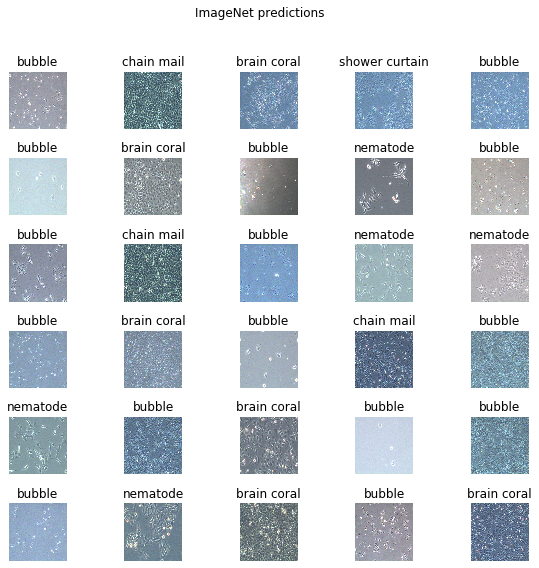

In [4]:
# Predict batch input

import PIL.Image as Image

result_batch = classifier.predict(image_batch)
print(f'Batch result shape: {result_batch.shape}')

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
print(f'Batch predicted class names: {predicted_class_names}')

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle('ImageNet predictions')

In [5]:
# Prepare transfer learning
## Download headless (without the top classification layer) model
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2' #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SHAPE+(3,))
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

## Frozen feature extraction layer
feature_extractor_layer.trainable = False

## Make a model for classification
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

(32, 1280)


In [6]:
## Check the model and prediction result
model.summary()

predictions = model(image_batch)
print(f'Prediction shape: {predictions.shape}')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
Prediction shape: (32, 3)


In [7]:
# Train build
## Compile model for train
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc'])

## Log class
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=10,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 30.0 steps
Epoch 1/10
30/30 [==============================] - 31s 1s/step - loss: 0.8692 - acc: 0.7812
Epoch 2/10
30/30 [==============================] - 29s 957ms/step - loss: 0.4313 - acc: 0.8750
Epoch 3/10
30/30 [==============================] - 27s 914ms/step - loss: 0.3163 - acc: 0.9375
Epoch 4/10
30/30 [==============================] - 28s 941ms/step - loss: 0.2605 - acc: 0.9688
Epoch 5/10
30/30 [==============================] - 28s 926ms/step - loss: 0.2201 - acc: 0.9688
Epoch 6/10
30/30 [==============================] - 28s 926ms/step - loss: 0.1944 - acc: 0.9688
Epoch 7/10
30/30 [==============================] - 28s 944ms/step - loss: 0.1726 - acc: 0.9062
Epoch 8/10
30/30 [==============================] - 29s 982ms/step - loss: 0.1580 - acc: 0.9375
Epoch 9/10
30/30 [==============================] - 30s 1000ms/step - loss: 0.1393 - acc: 1.0000
Epoch 10/10
30/30 [==============================] - 28s 947ms/step - loss: 0.1260 - acc: 0.9688


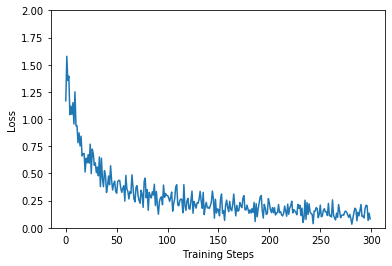

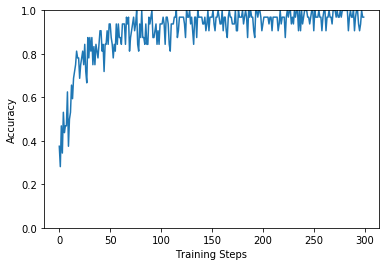

In [8]:
# Draw loss rate
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

# Draw accurary
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

Classes: ['Hek293' 'Hela' 'Pc12']


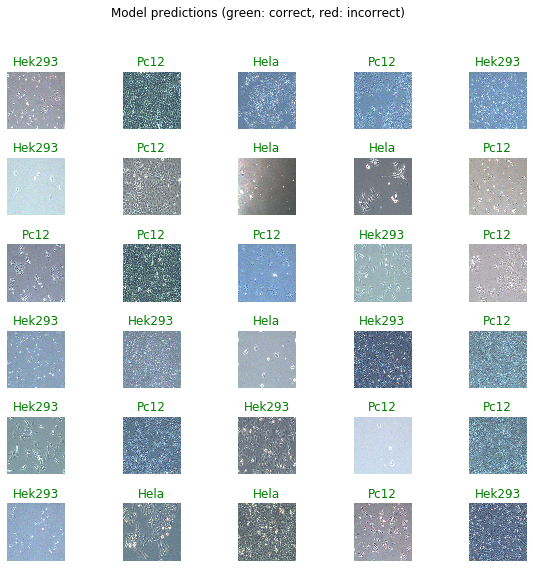

In [9]:
# Plot results
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(f'Classes: {class_names}')

## get result labels
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

## plot
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

In [10]:
# Export model
import time
t = time.time()

export_path = f'/tmp/saved_models/{int(t)}'
model.save(export_path, save_format='tf')

print(f'Export the model to {export_path}')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1580265461/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1580265461/assets


Export the model to /tmp/saved_models/1580265461


In [11]:
# Check the exported model
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

print(f'Comparison between own model and exported model {abs(reloaded_result_batch - result_batch).max()}')

Comparison between own model and exported model 0.0
